In [16]:
import os
import math
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("davinwijaya/customer-retention")

print("Path to dataset files:", path)

Path to dataset files: /Users/shawn/.cache/kagglehub/datasets/davinwijaya/customer-retention/versions/1


In [2]:
# 2. List files in the downloaded directory (might be nested)
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            break  # Use the first CSV file found

# 3. Load the CSV
df = pd.read_csv(csv_path)

# 4. Preview the data
display("Loaded:", csv_path)
display(df.head())

'Loaded:'

'/Users/shawn/.cache/kagglehub/datasets/davinwijaya/customer-retention/versions/1/data.csv'

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [4]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


- `recency` : months since last purchase (마지막 구매하고 지난 개월 수)
- `history` : $value of the historical purchases (이전에 구매한 달러 금액)
- `used_discount` : indicates if the customer used a discount before (이전에 할인 받은 내역이 있는지)
- `used_bogo` : indicates if the customer used a buy one get one before (1+1 혜택을 이용한적 있는지)
- `zip_code` : class of the zip code as Suburban/Urban/Rural (고객 주소)
- `is_referral` : indicates if the customer was acquired from referral (추천을 통해 유입되었는지)
- `channel` : channels that the customer using, Phone/Web/Multichannel (어느 채널을 사용했는지)
- `offer` : the offers sent to the customers, Discount/Buy One Get One/No Offer (회사가 고객에게 보낸 혜택 (Discount / Buy One Get One / No Offer))
- `conversion` : customer conversion(buy or not)

referral -> channel -> offer -> (used_discount/used_bogo) -> conversion -> (RM 분석)

In [6]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


# 1. referral 영향 여부 분기

In [26]:
df_is_referral = df[df['is_referral'] == 1]
df_is_not_referral = df[df['is_referral'] == 0]
display(df_is_referral)
display(df_is_not_referral)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
...,...,...,...,...,...,...,...,...,...
63991,1,306.10,1,0,Surburban,1,Phone,Buy One Get One,0
63992,1,519.69,1,1,Urban,1,Phone,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
13,2,101.64,0,1,Urban,0,Web,Discount,1
...,...,...,...,...,...,...,...,...,...
63990,6,80.02,0,1,Surburban,0,Phone,No Offer,0
63993,4,374.07,0,1,Surburban,0,Phone,Buy One Get One,0
63994,7,86.46,0,1,Urban,0,Web,Discount,0
63995,10,105.54,1,0,Urban,0,Web,Discount,0


## 1-1. 추천으로 유입된 고객군에 대한 시각화

In [20]:
def visualize_columns_distribution(df: pd.DataFrame, n_cols: int = 3):
    """
    Visualize the distribution of columns in a DataFrame.
    """
    n_rows = math.ceil(len(df.columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        if df[col].dtype != "float64":
            sns.countplot(data=df, x=col, ax=axes[i])
        else:
            sns.histplot(data=df, x=col, ax=axes[i], kde=True)

        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()

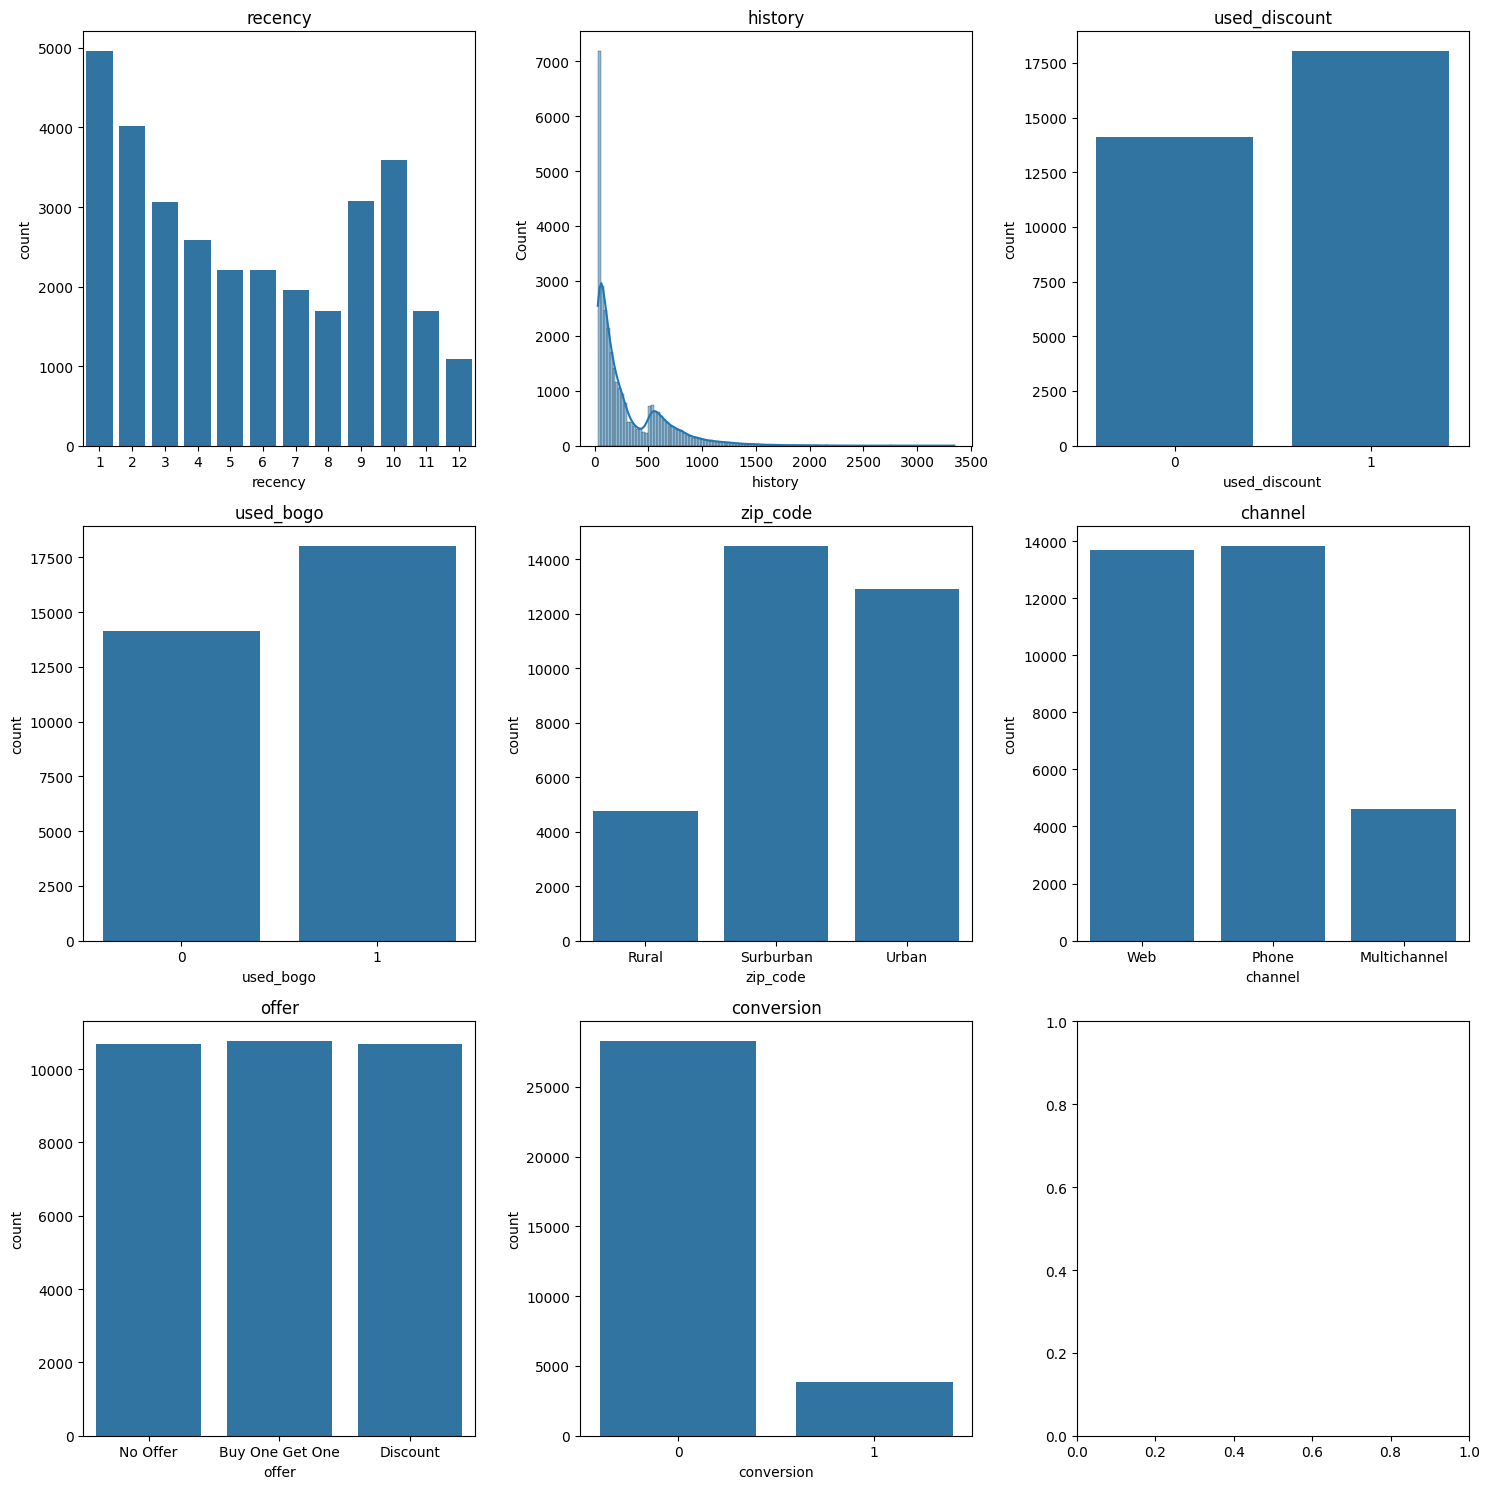

In [27]:
df_is_referral = df_is_referral.drop(columns=['is_referral'])
visualize_columns_distribution(df_is_referral, n_cols=3)

## 1-2. 능동적으로 유입된 고객군에 대한 시각화

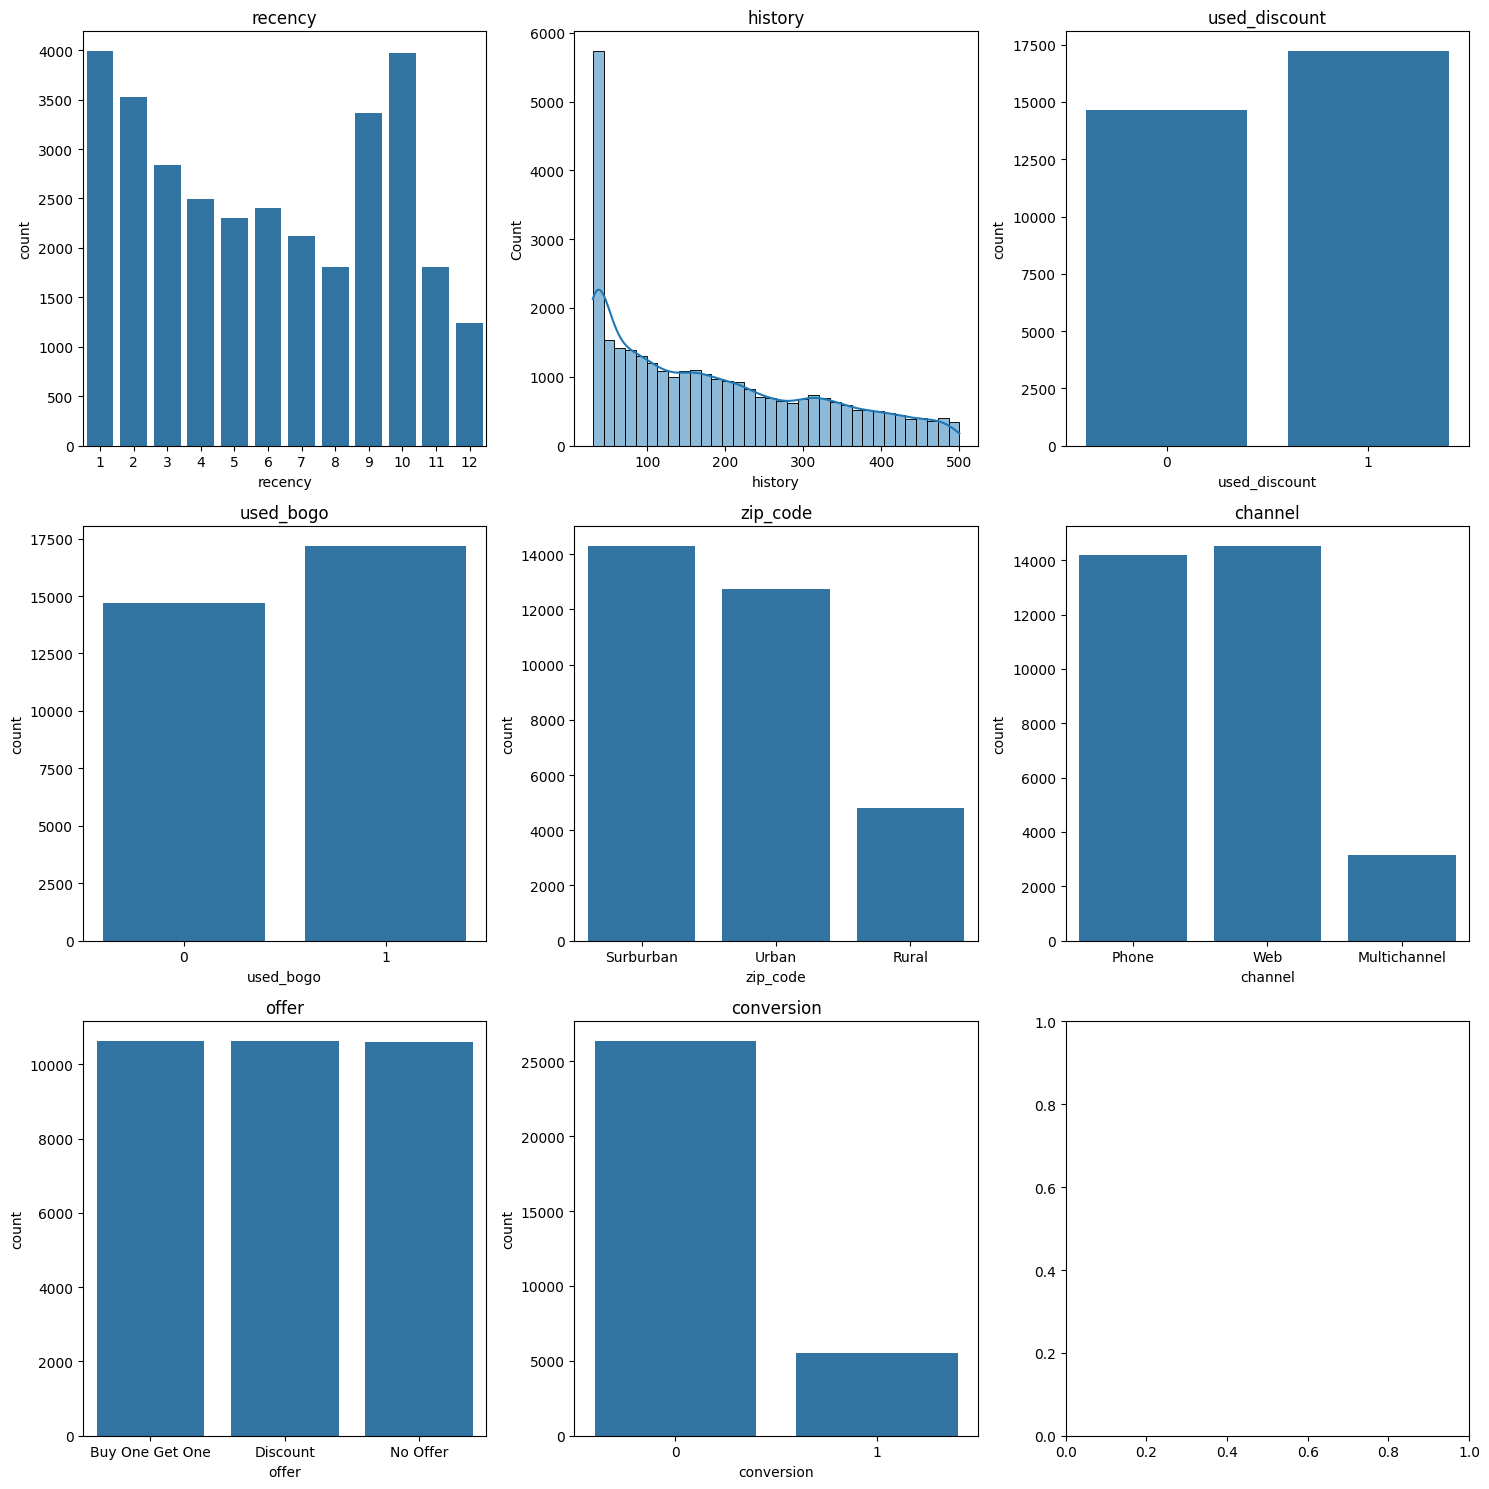

In [28]:
df_is_not_referral = df_is_not_referral.drop(columns=['is_referral'])
visualize_columns_distribution(df_is_not_referral, n_cols=3)

결론 : referral은 다른 feature에 별로 영향이 없는 것으로 보임

# 2. channel 영향 여부 분기

## 2-1. referral 중에서 채널별 분기

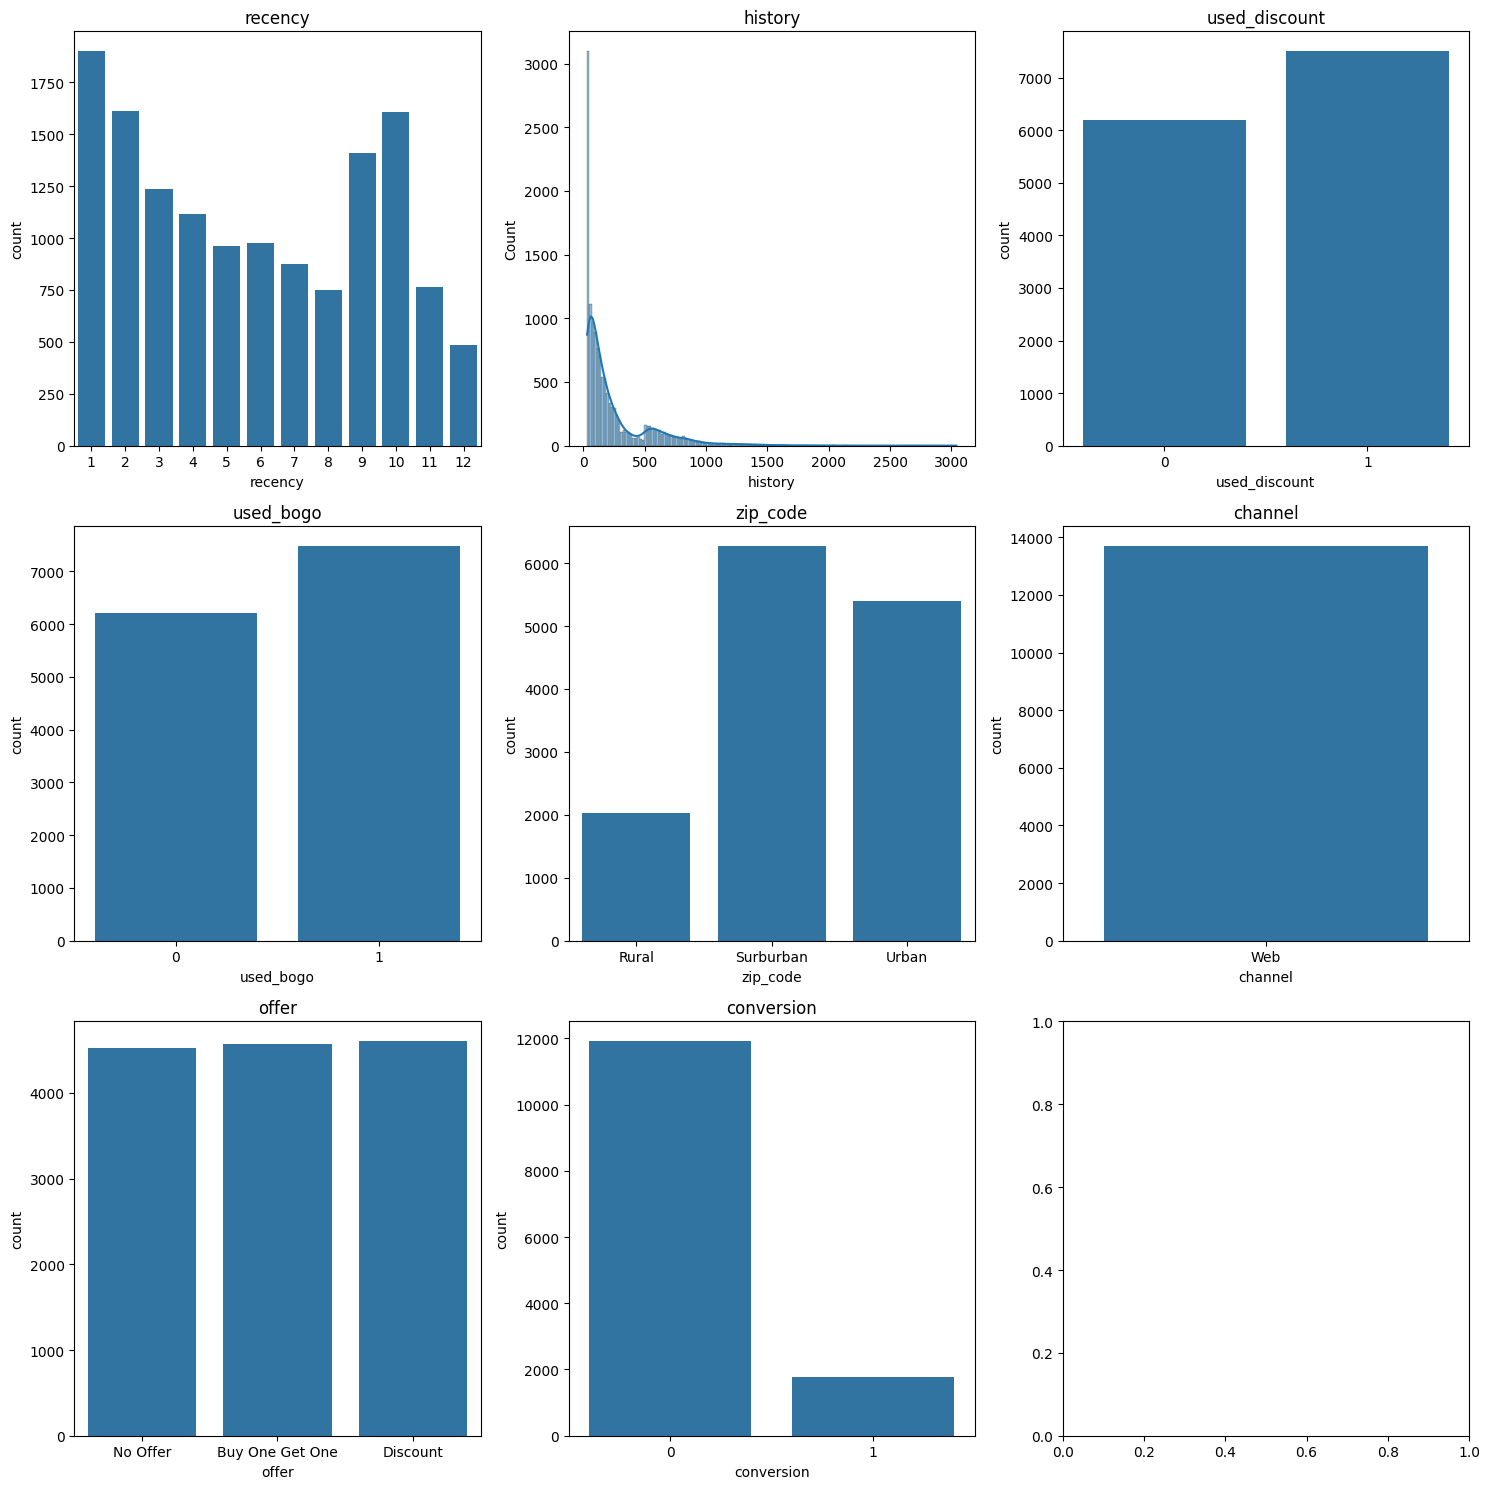

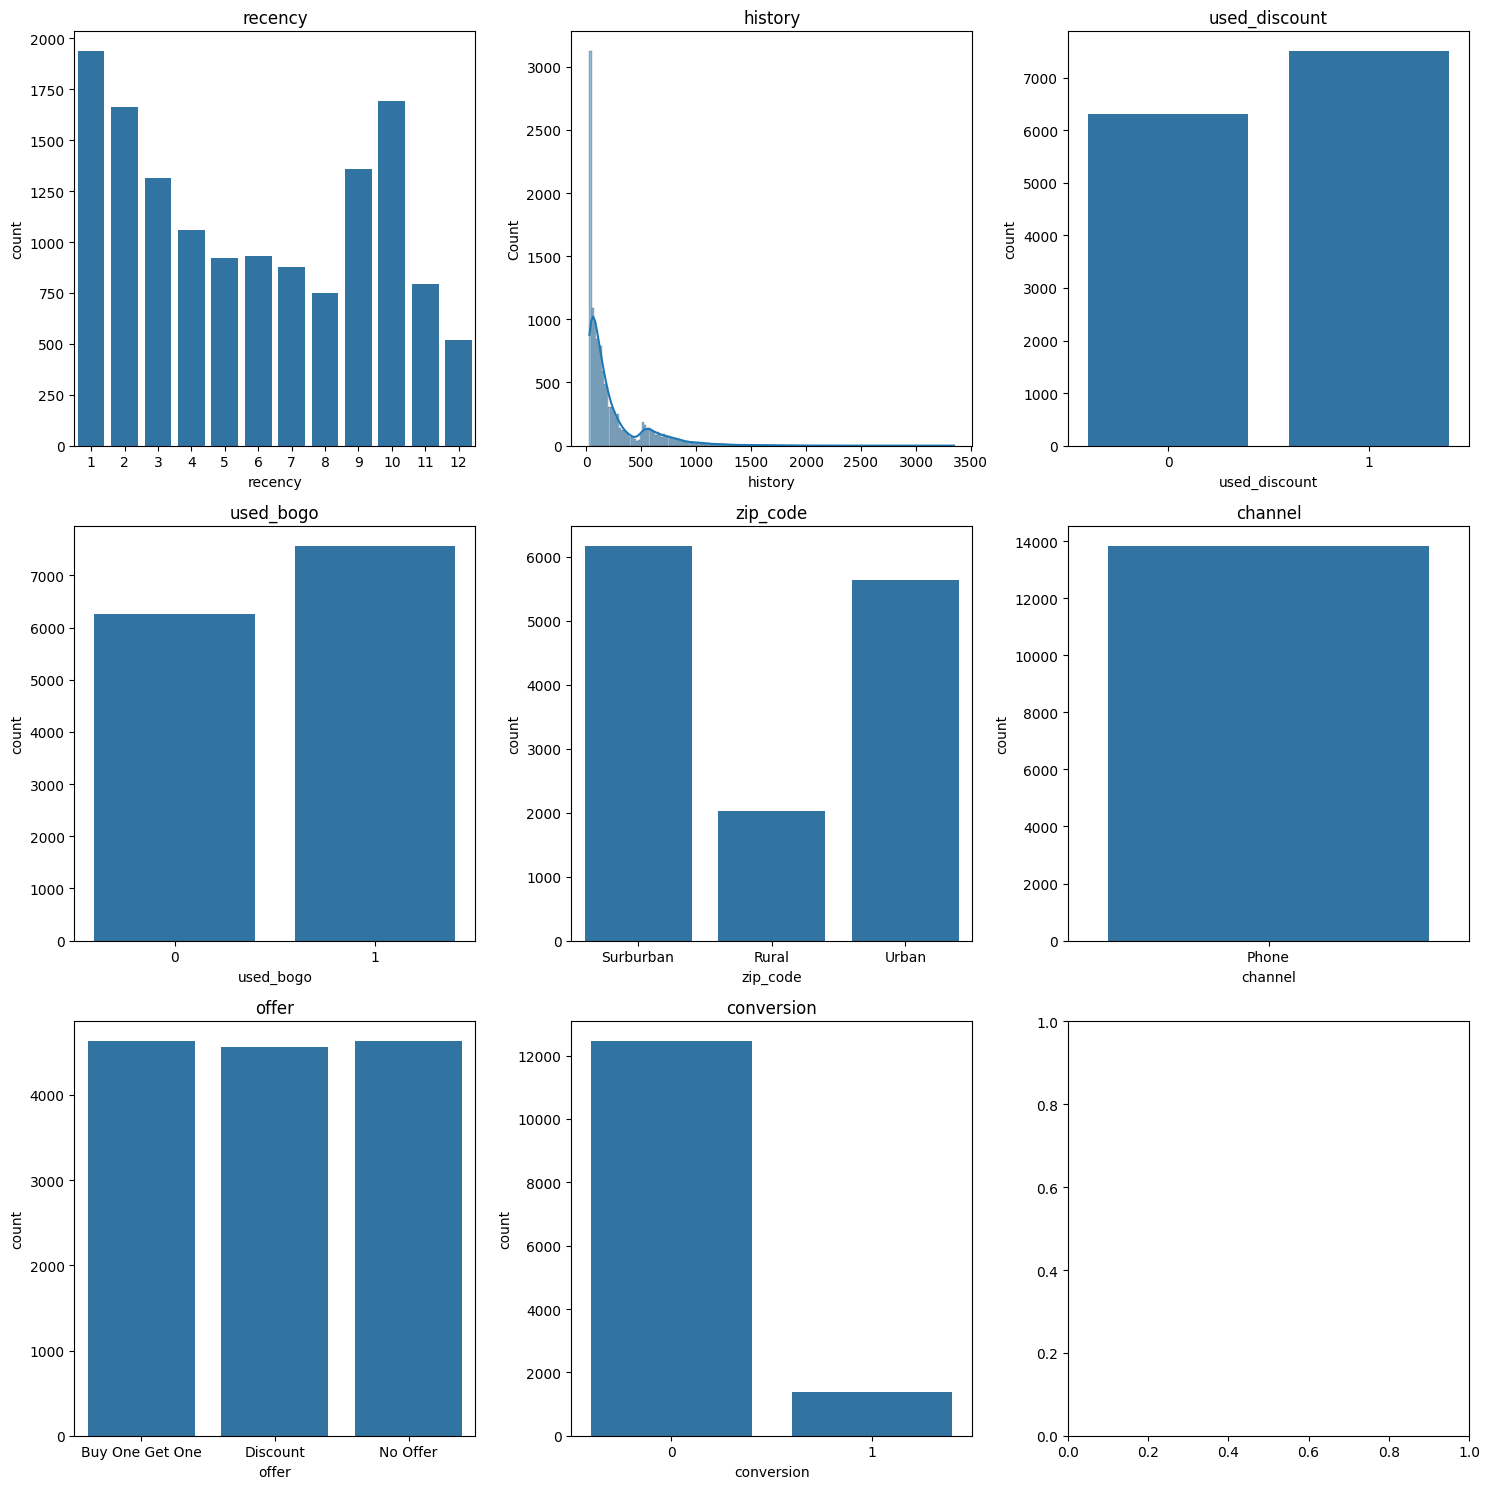

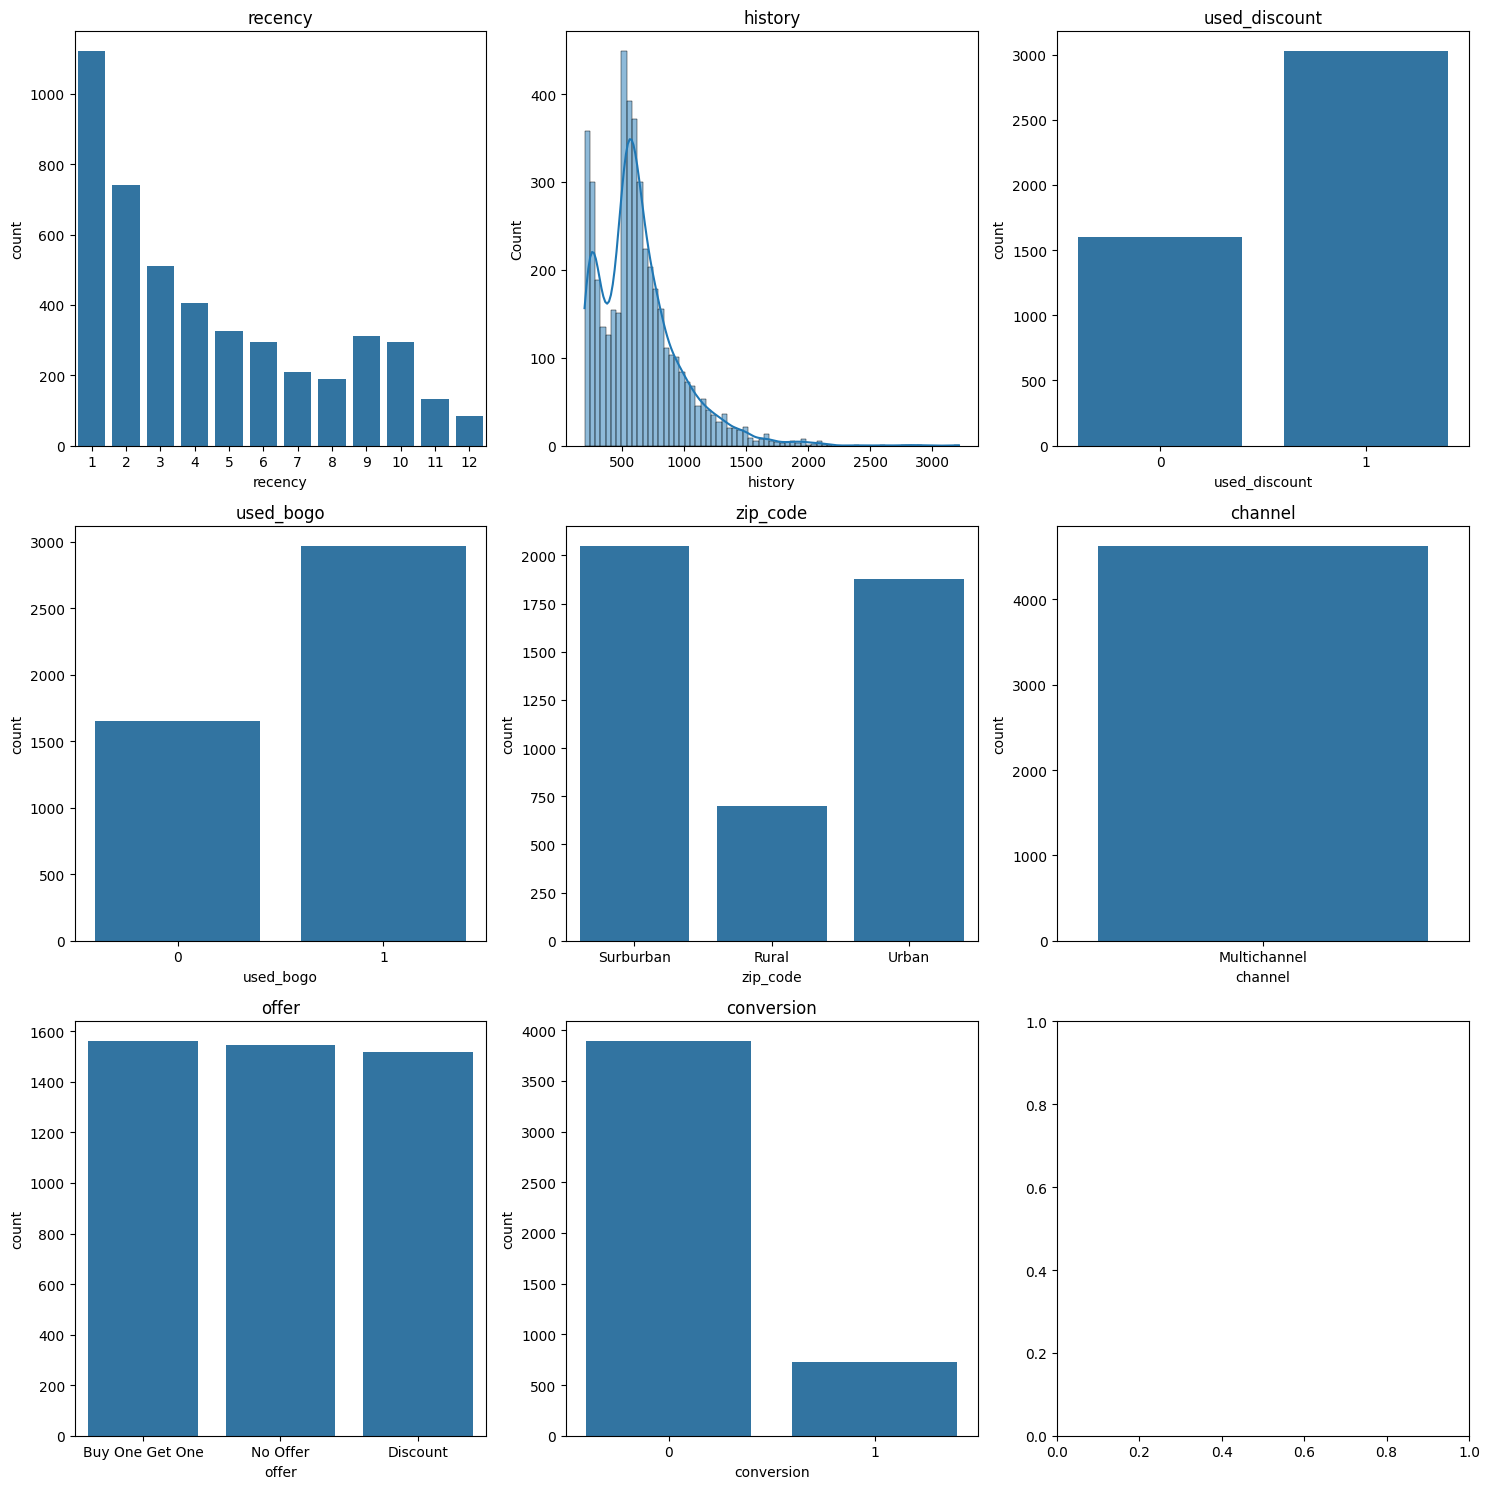

In [35]:
df_is_referral_web, df_is_referral_phone, df_is_referral_multi_channel = (
    df_is_referral[df_is_referral['channel'] == channel] for channel in df_is_referral["channel"].unique()
)

visualize_columns_distribution(df_is_referral_web, n_cols=3)
visualize_columns_distribution(df_is_referral_phone, n_cols=3)
visualize_columns_distribution(df_is_referral_multi_channel, n_cols=3)

## 2-2. referral 아닌 것중에서 채널별 분기

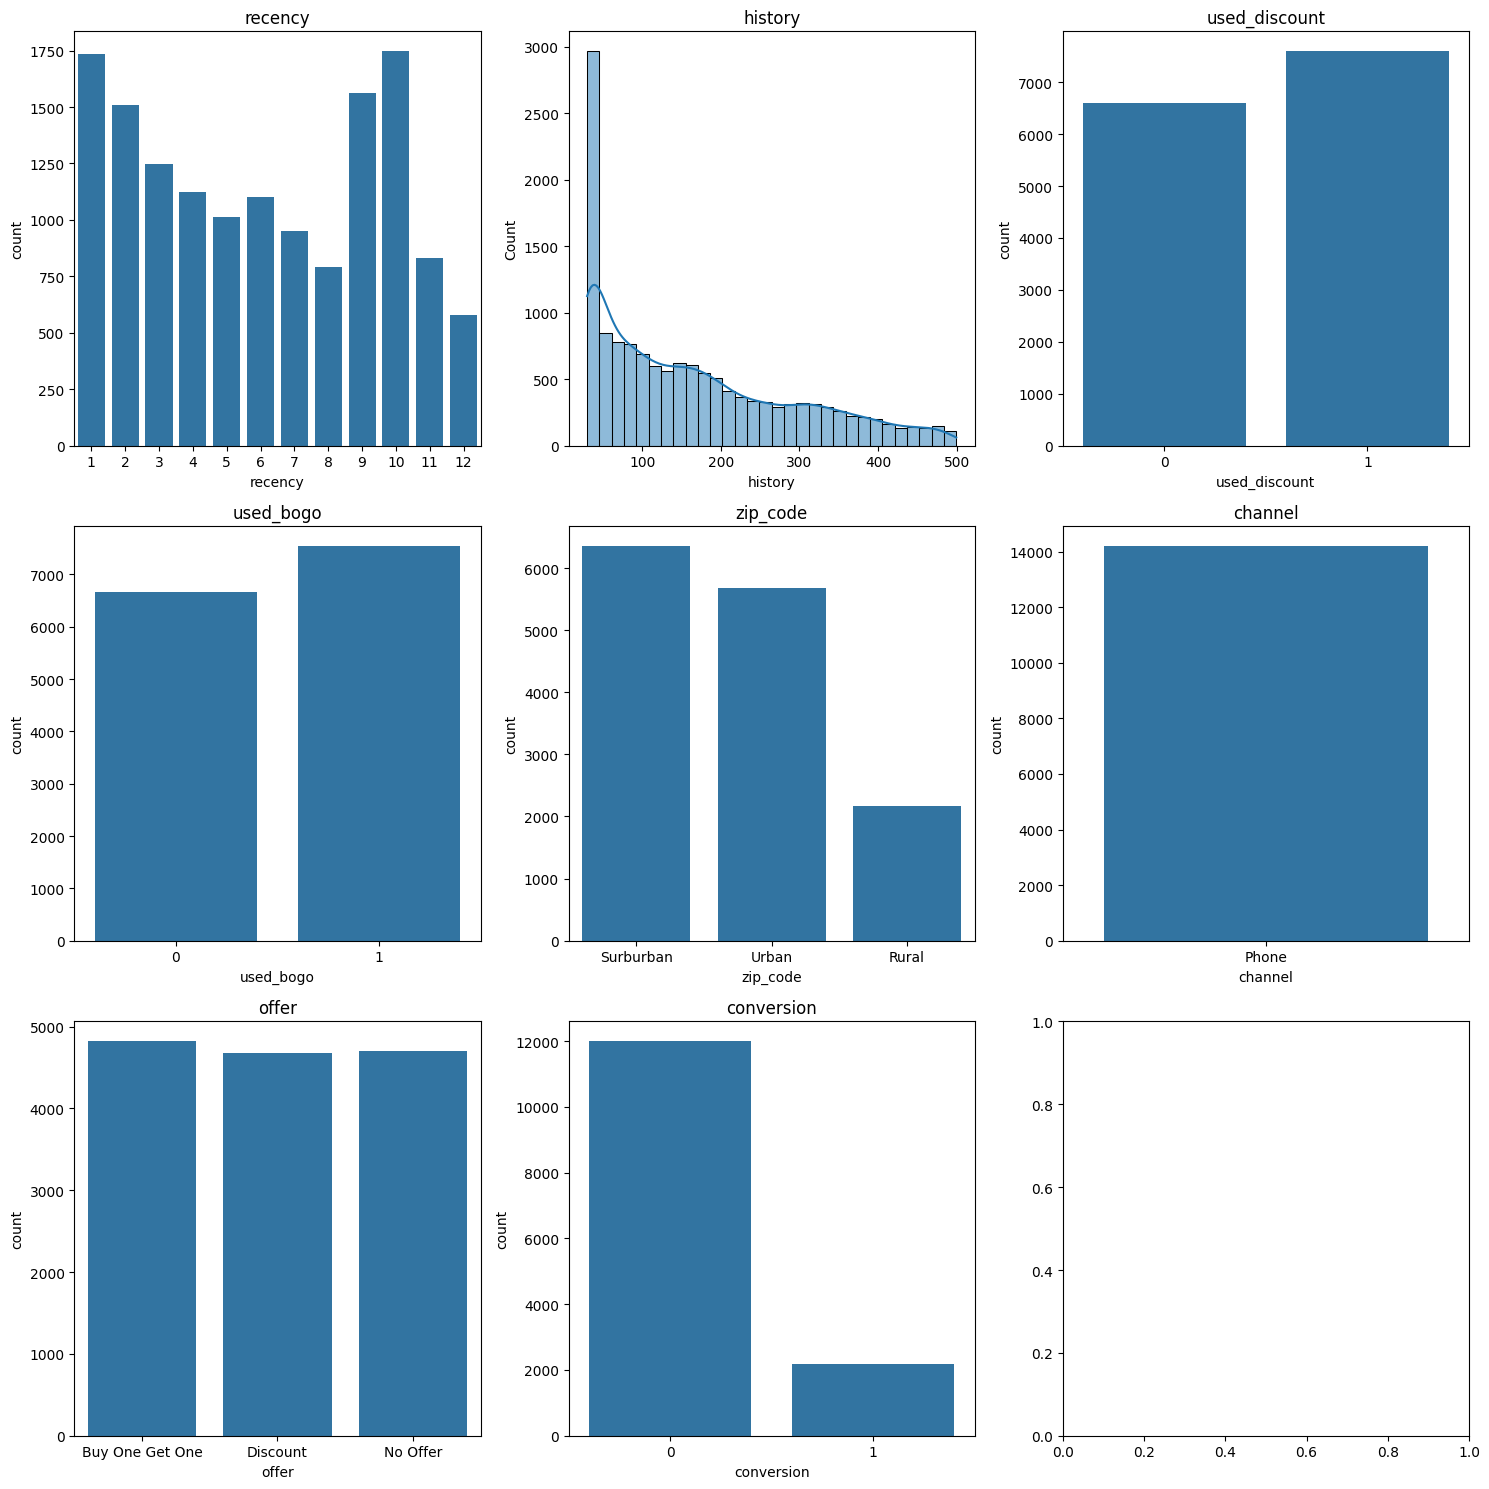

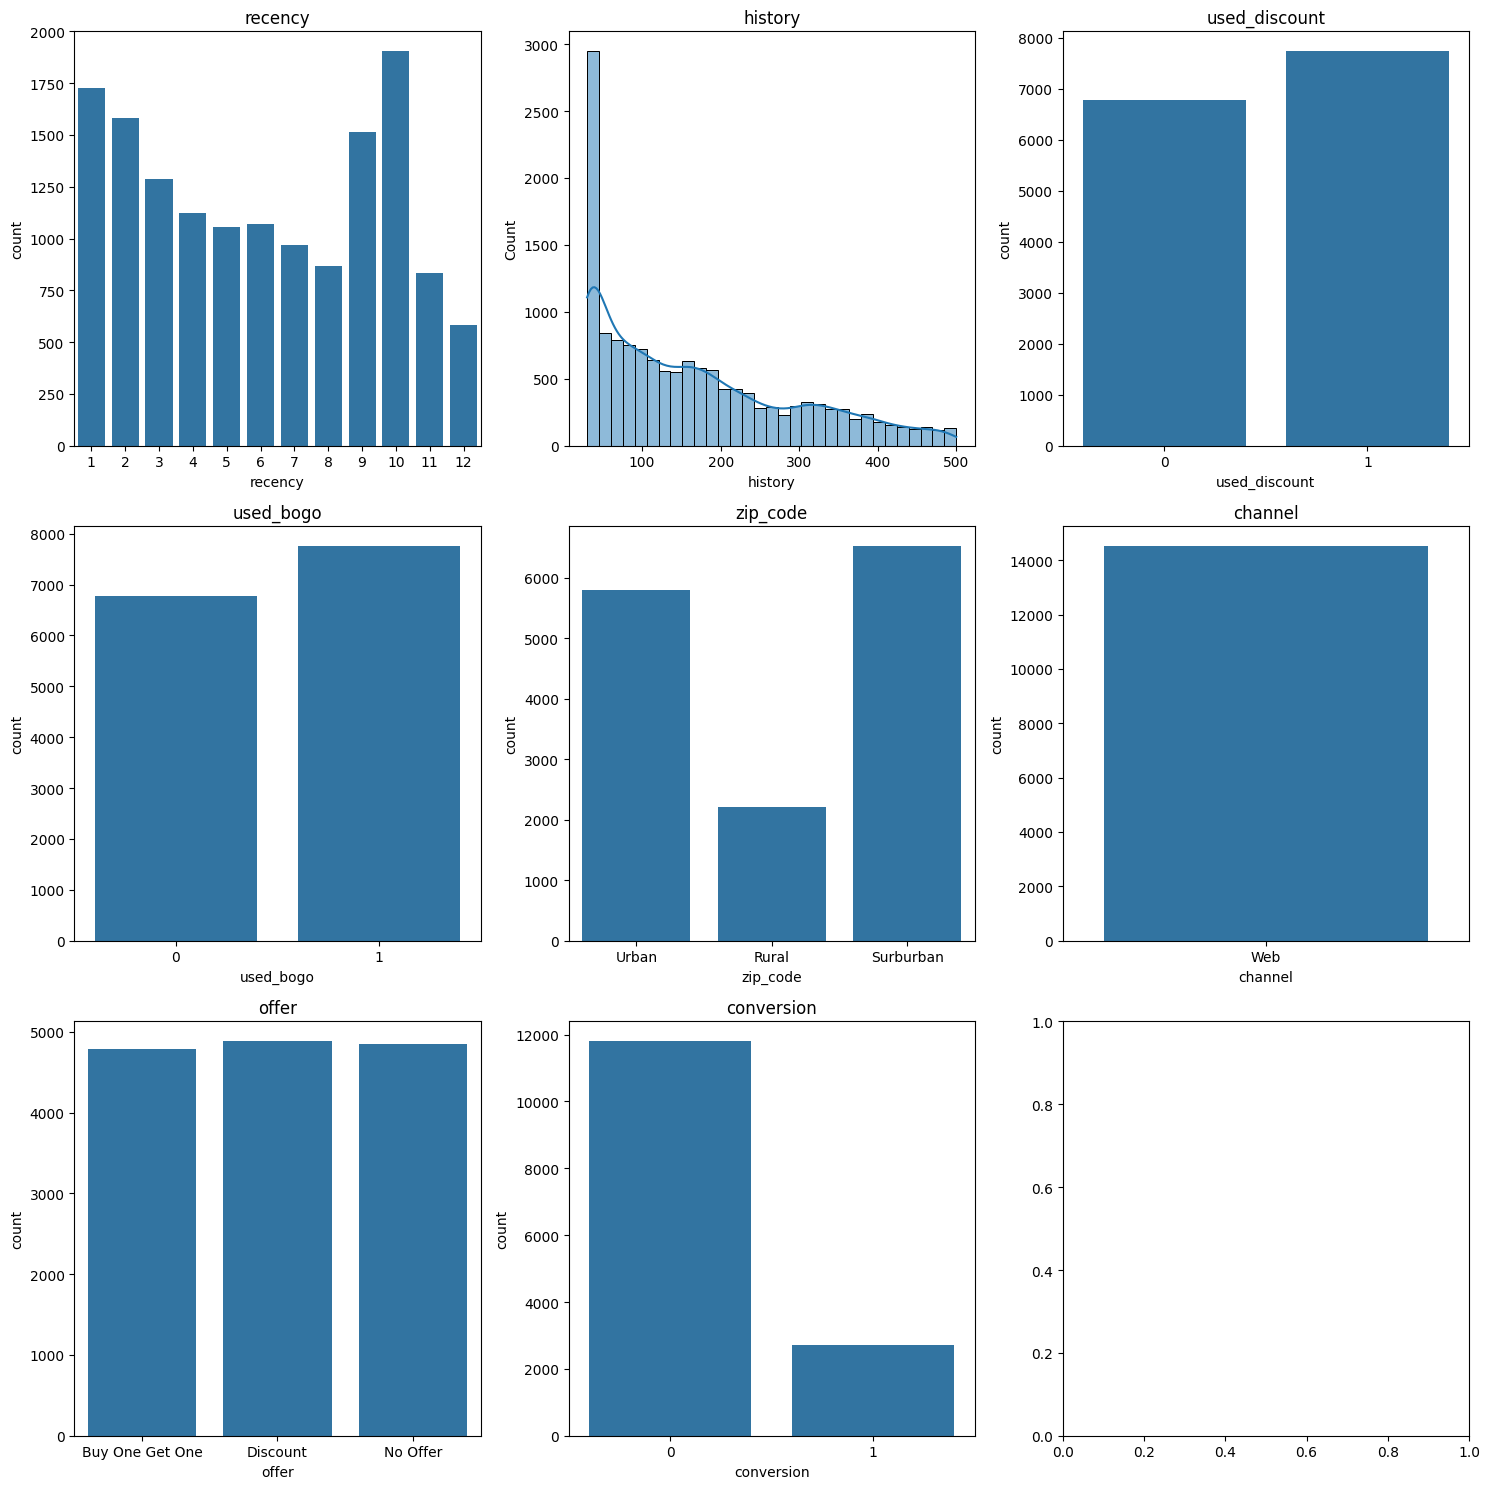

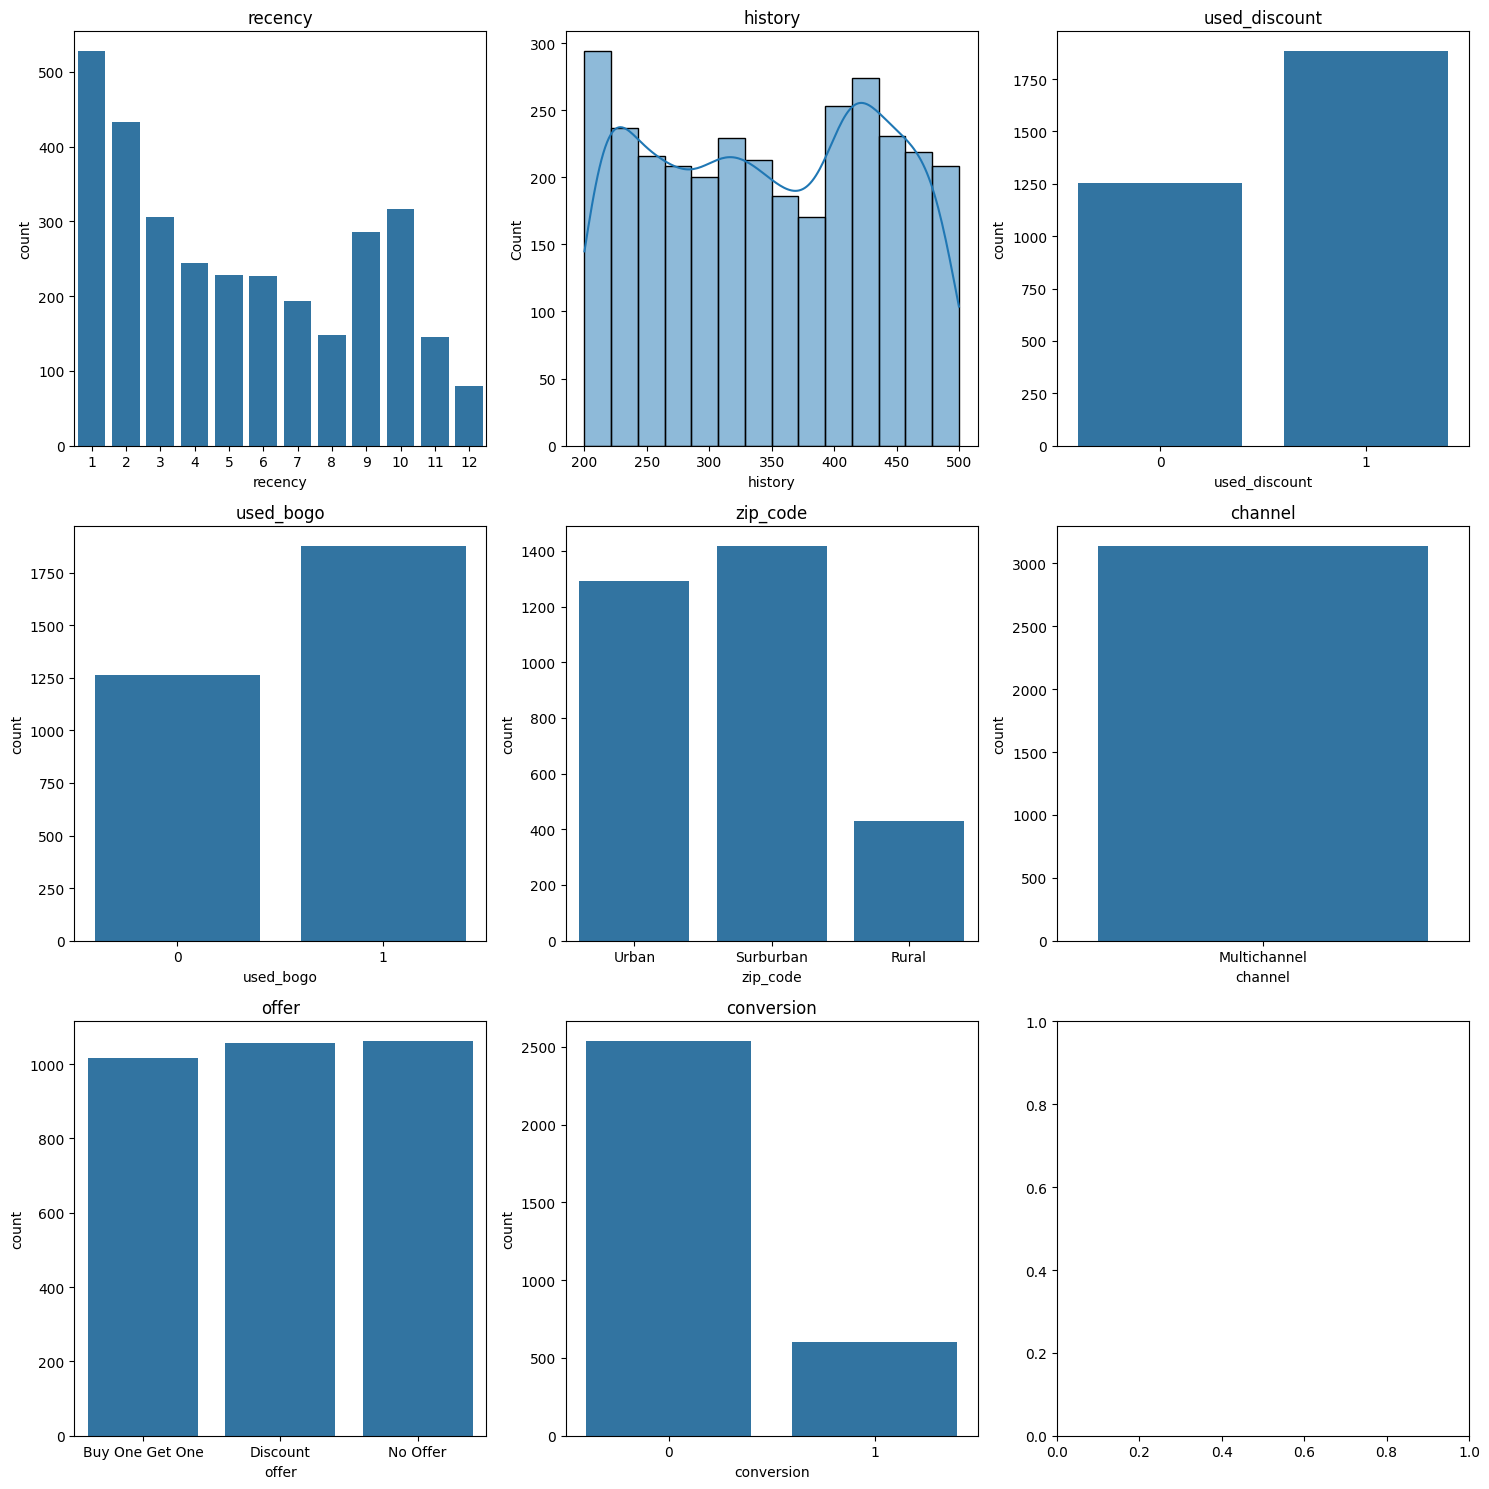

In [ ]:
df_is_not_referral_web, df_is_not_referral_phone, df_is_not_referral_multi_channel = (
    df_is_not_referral[df_is_not_referral['channel'] == channel] for channel in df_is_not_referral["channel"].unique()
)

visualize_columns_distribution(df_is_not_referral_web, n_cols=3)
visualize_columns_distribution(df_is_not_referral_phone, n_cols=3)
visualize_columns_distribution(df_is_not_referral_multi_channel, n_cols=3)

결론 : 능동적으로 유입되며, 복수개의 채널을 사용한 고객군이 지불한 금액이 타 고객군에 비해 편향없이 많은 금액을 지불한 경향을 보임

# 3. referral이 아니고 multi channel인 데이터 중에서 offer별로 시각화

In [36]:
df_is_not_referral_multi_channel

,recency,history,used_discount,used_bogo,zip_code,channel,offer,conversion
35,4,218.72,0,1,Urban,Multichannel,Buy One Get One,0
140,9,228.80,1,0,Surburban,Multichannel,Discount,1
180,4,292.61,1,0,Surburban,Multichannel,No Offer,0
188,9,311.81,1,0,Urban,Multichannel,Buy One Get One,1
193,10,307.64,0,1,Urban,Multichannel,Discount,0
...,...,...,...,...,...,...,...,...
63906,4,311.63,0,1,Urban,Multichannel,No Offer,0
63932,1,426.36,1,1,Surburban,Multichannel,Discount,1
63935,4,353.47,1,1,Urban,Multichannel,Discount,0
63936,10,442.52,0,1,Surburban,Multichannel,Discount,1


In [37]:
df_is_not_referral_multi_channel["offer"].unique()

array(['Buy One Get One', 'Discount', 'No Offer'], dtype=object)

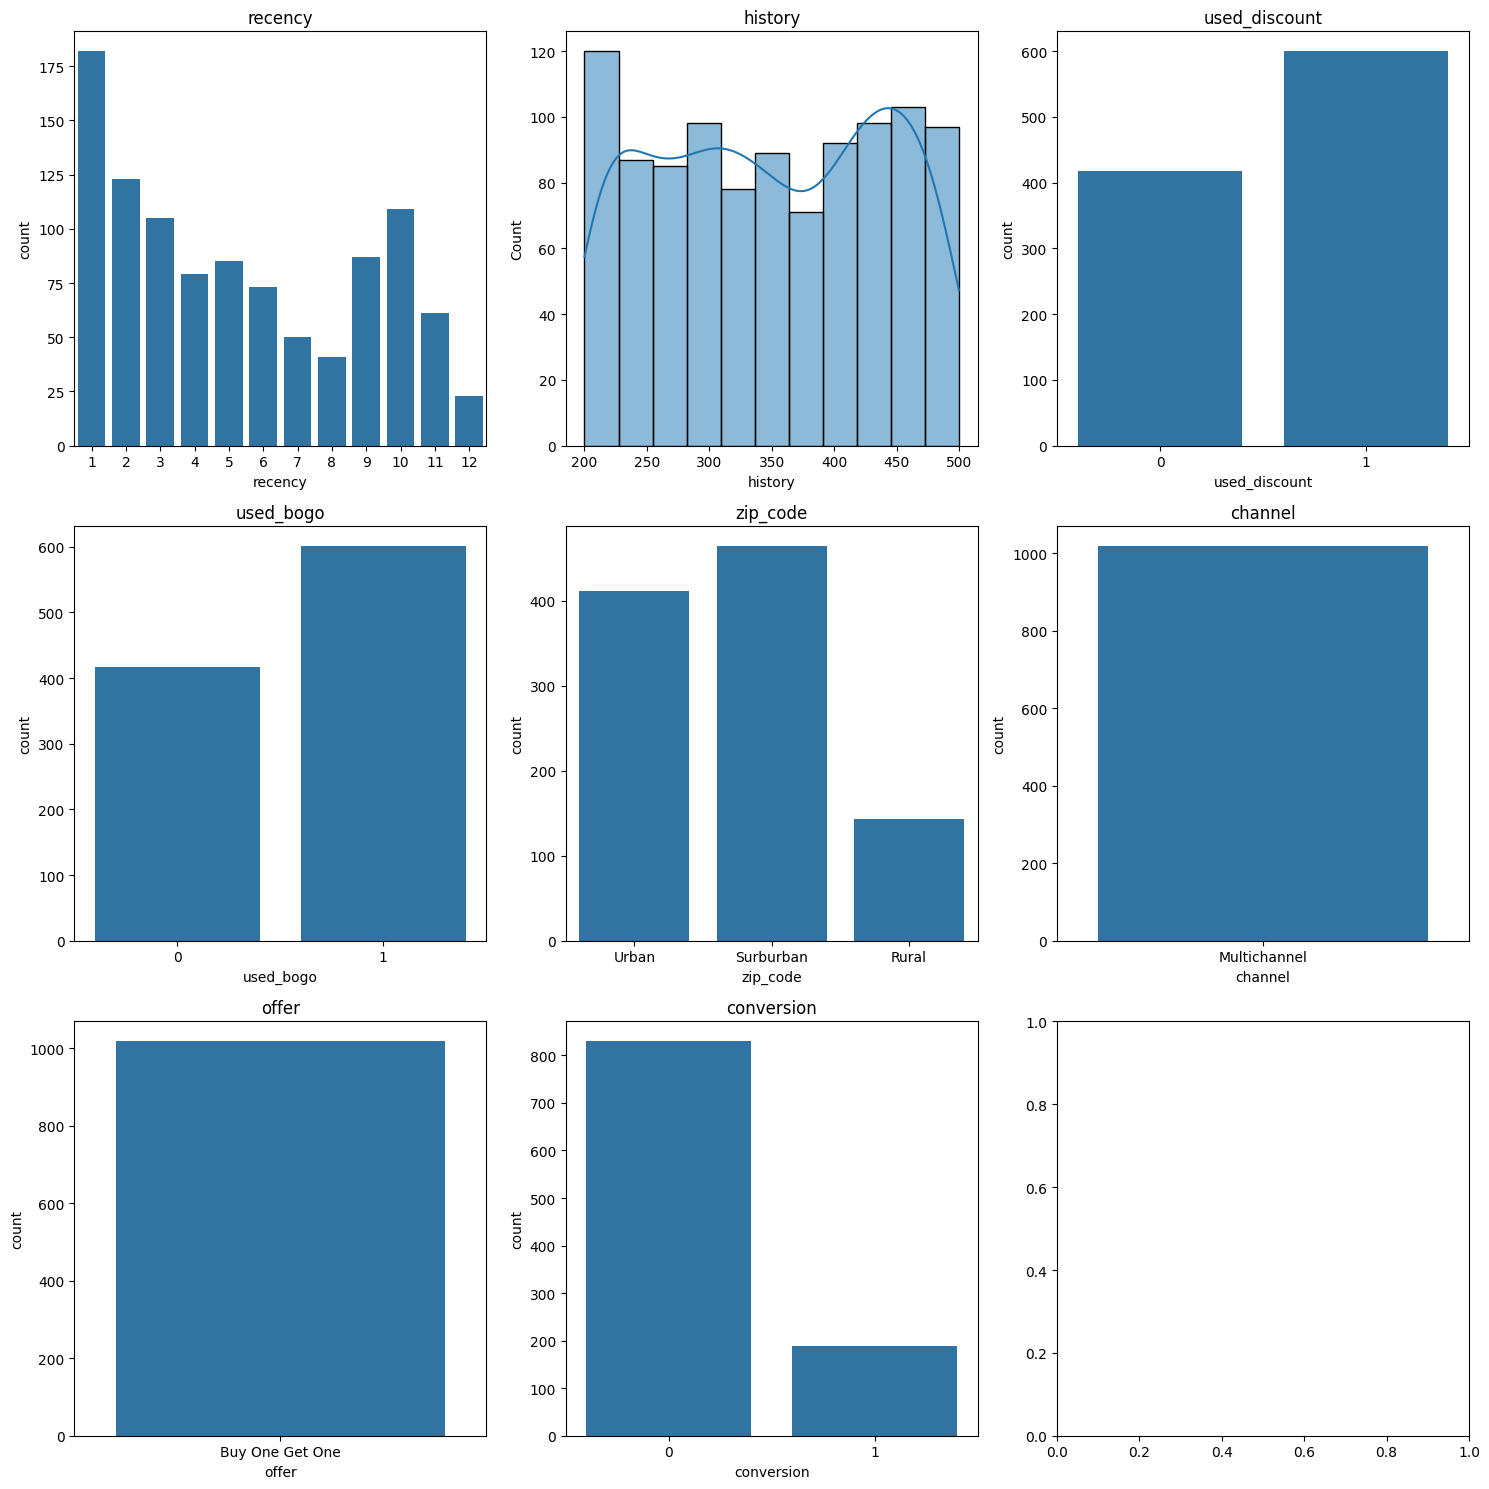

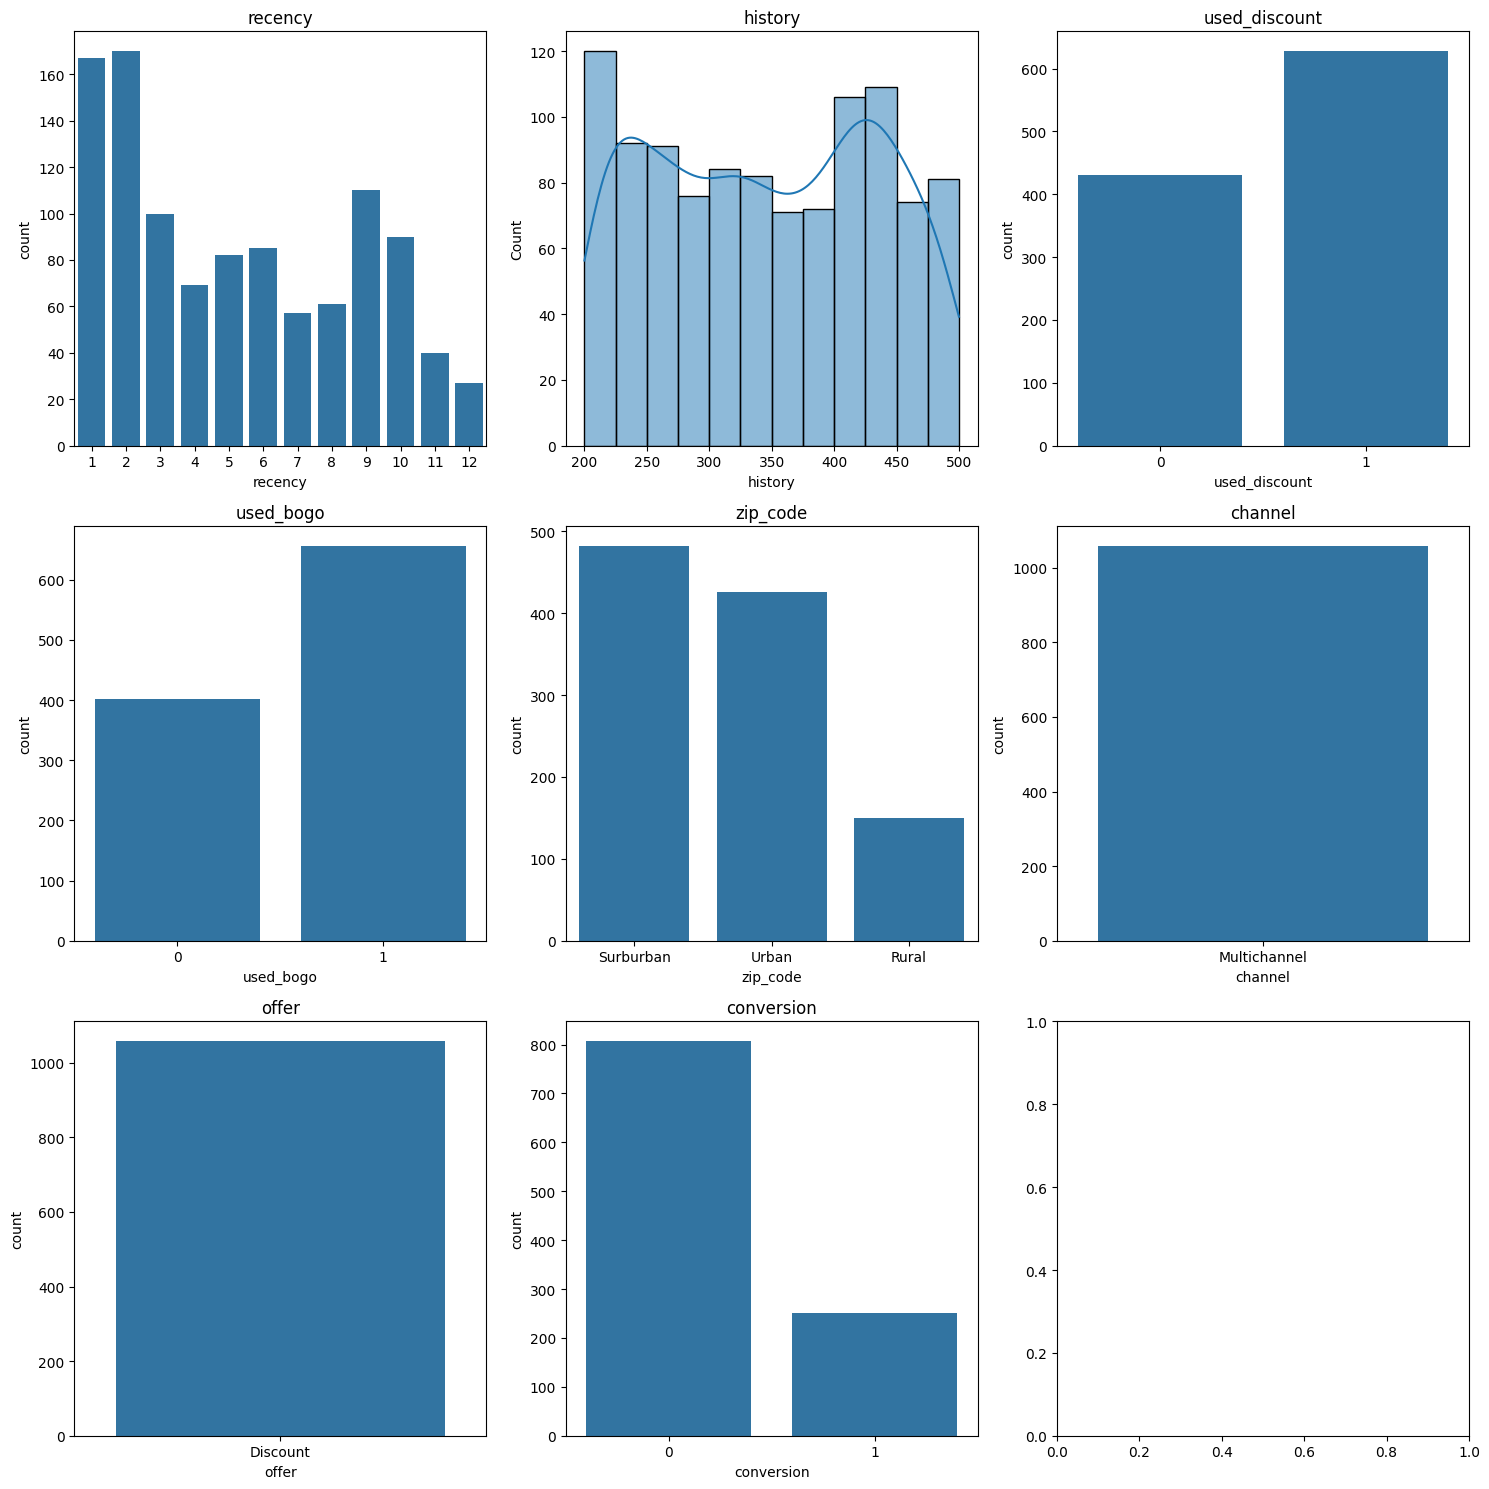

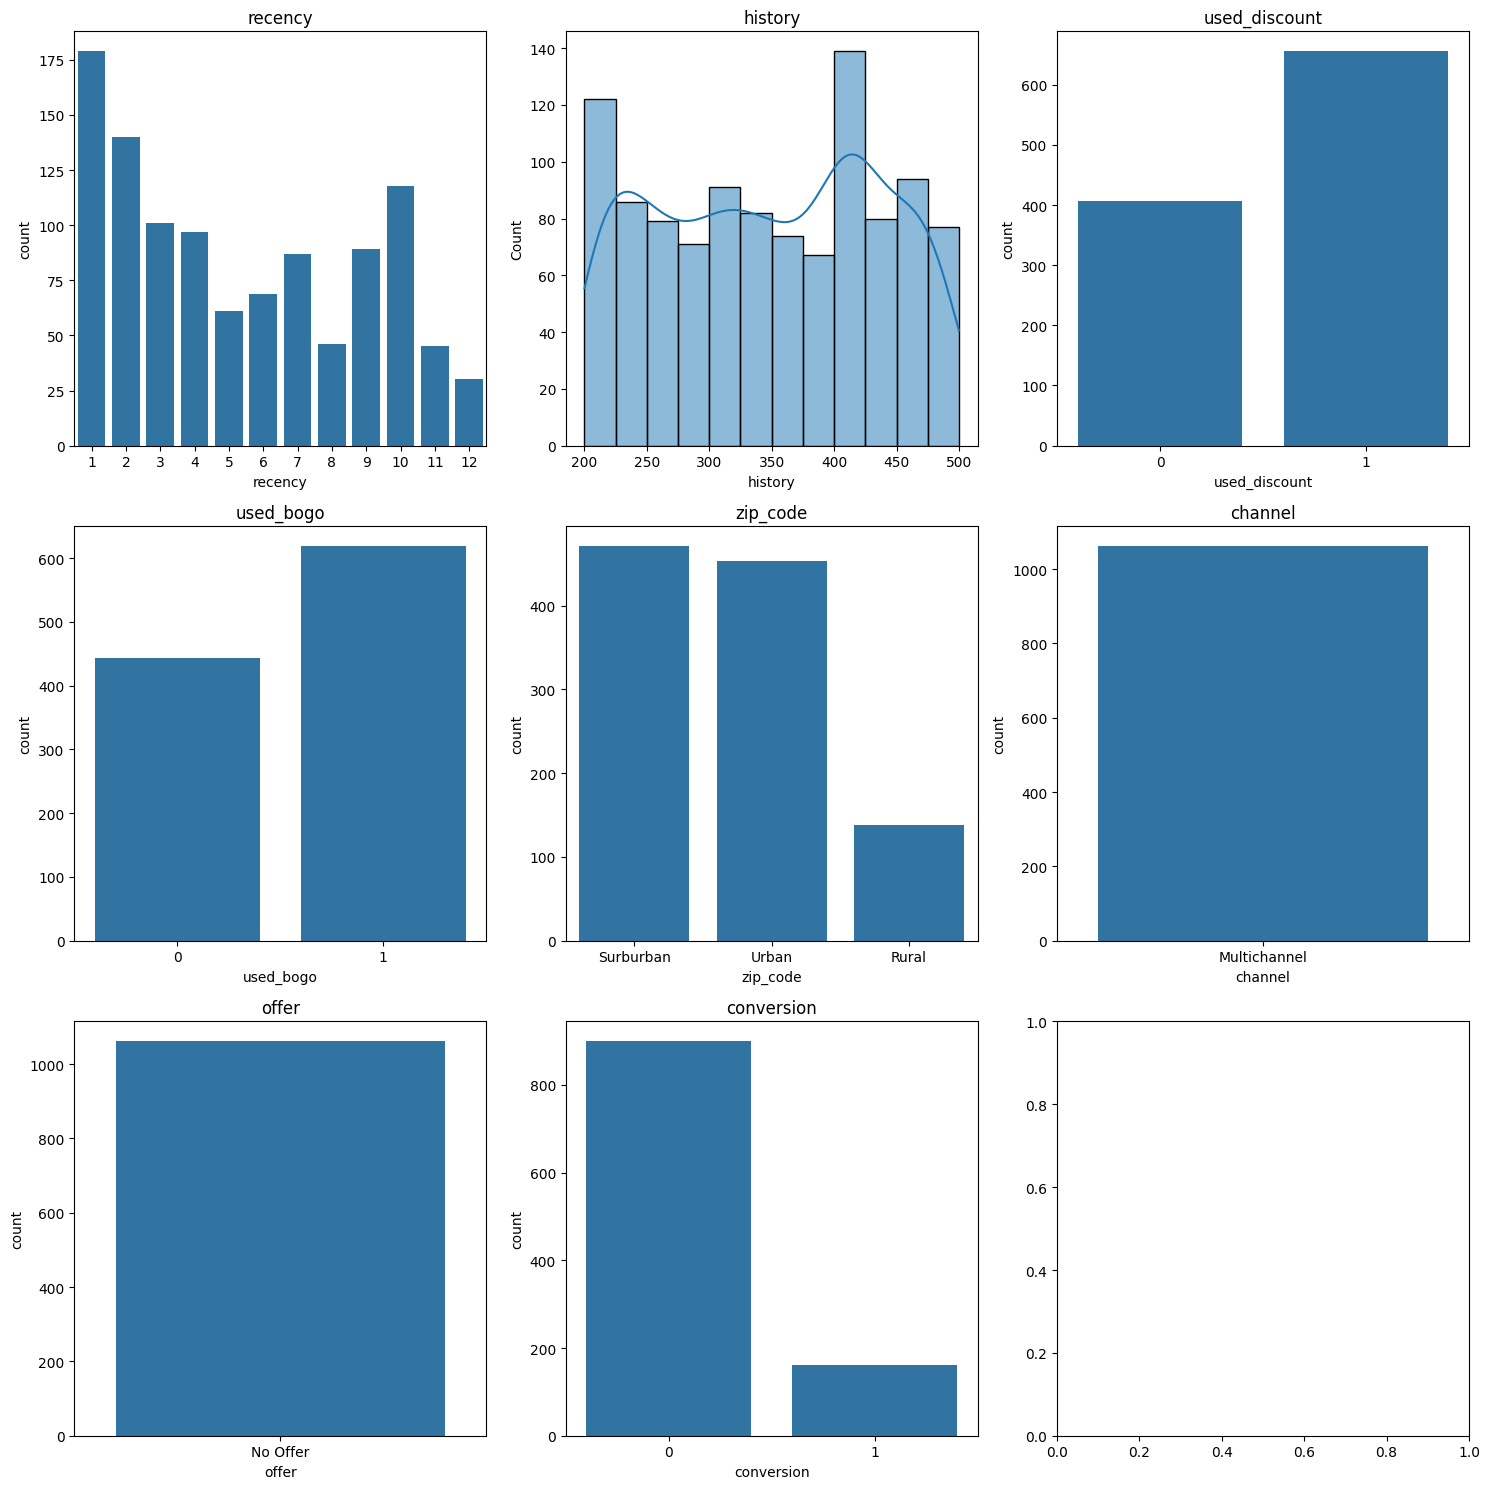

In [38]:
df_is_not_referral_multi_channel_bogo, df_is_not_referral_multi_channel_discount, df_is_not_referral_multi_channel_nooffer = (
    df_is_not_referral_multi_channel[df_is_not_referral_multi_channel['offer'] == offer] for offer in df_is_not_referral_multi_channel["offer"].unique()
)

visualize_columns_distribution(df_is_not_referral_multi_channel_bogo, n_cols=3)
visualize_columns_distribution(df_is_not_referral_multi_channel_discount, n_cols=3)
visualize_columns_distribution(df_is_not_referral_multi_channel_nooffer, n_cols=3)